In [3]:
%%time
from analysis_utils import *
import numpy as np
%load_ext autoreload
import pandas as pd
scalingFactor = 200
rxndiff=dict()

print('Starting scaling = ', scalingFactor)
NR_scaledrates = {'k1r':718*200/scalingFactor,'k2f':1475*200/scalingFactor,'k2r_nr':1120*200/scalingFactor,'k3_nr':6*200/scalingFactor,'k4':209*200/scalingFactor}


#Growth rate = 3.0
path = "/Users/Akshay/Documents/TranslationDynamics/data/"

gr_sim = dict()

data = "191003_2210/"
for i in range(1,7):
    sim_i = computeTransportRxnTimes(path+data, 1e15, 1e15, 100*(i-1),100*(i-1)+100,cogtRNANum=i, ribosomeNum = 7,scaling=scalingFactor, NR_scaling = NR_scaledrates)
    gr_sim[i] = (CellLatencies(sim_i))

data = "191105_0908/"
for i in range(7,14):
    sim_i = computeTransportRxnTimes(path+data, 1e15, 1e15, 100*(i-1-6),100*(i-1-6)+100,cogtRNANum=i, ribosomeNum = 7,scaling=scalingFactor, NR_scaling = NR_scaledrates)
    gr_sim[i] = (CellLatencies(sim_i))


gr_dict = {'gr_1':gr_sim}

def computedElongationLatency_gr3_v2(gr25_ptRNA,gr25_pCodon,gr_dict):
    import numpy as np

    transportRxnResults = transportRxnCalc(gr_dict,gr25_ptRNA,gr25_pCodon)

    search_list = transportRxnResults[0]
    rxndiff['30'] = transportRxnResults[1:]
    return([rxndiff[d][2][0]+(1000/1475+1000/1529+1000/209+1000/200+1000/32) for d in rxndiff],[rxndiff[d][5][0] for d in rxndiff])

Starting scaling =  200
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
CPU times: user 53.9 s, sys: 610 ms, total: 54.5 s
Wall time: 55.3 s


In [10]:
###### Genetic algorithm for just tRNA shuffling ########

def run_ga_tRNASweep_multithread(codon_arr,elong_arr,tRNA_arr,gr_dict,minRange,maxRange):
    import gc
    from joblib import Parallel, delayed
    import multiprocessing   
    num_cores = 16

    #### Compute fitness
    fitness = (np.array(elong_arr))/sum(np.array(elong_arr))

    #### Number of candidates n removing as well as n mating to create n offspring
    n = 10

    #### Identify the least fit candidates from the population
    cull_indices = np.argpartition(fitness, n)[:n]

    #### Choose parents based on weighting fitness
    import random
    parent_indices = np.argpartition(fitness, n)[-n:]
    tRNA_arr=np.array(tRNA_arr)
    parents = tRNA_arr[parent_indices]

    #### Mate k random pairs of 2 without replacement and renormalize
    k=5
    couples = np.random.choice(np.arange(len(parents)), size = (k,2),replace=False)
    recombination_rate = 0.1
    mutation_rate  = 0.05

    recombined_children = list()
    recombined_children_elongt = list()
    for couple_index in couples:
        couple = parents[couple_index]
        recombination_num = int(len(couple[0])*recombination_rate)
        recombination_locs = np.random.choice(len(couple[0]),recombination_num)
        recombination_values_0 = couple[0][recombination_locs] 
        couple[0][recombination_locs] = couple[1][recombination_locs]
        couple[1][recombination_locs] = recombination_values_0
        
        #### Mutate children
        mutation_num = int(len(couple[0])*mutation_rate)
        recombination_locs = np.random.choice(len(couple[0]),mutation_num)
        couple[0][recombination_locs] = np.random.uniform(minRange,maxRange,mutation_num)
        couple[1][recombination_locs] = np.random.uniform(minRange,maxRange,mutation_num)
        
        ### Re-normalize each recombined children
        child_0 = couple[0]/np.sum(couple[0])
        child_1 = couple[1]/np.sum(couple[1])
        
        ### Add children to list
        recombined_children.append(list(child_0))
        recombined_children.append(list(child_1))
        
    #### Compute elong_t of the recombined children, multithreaded
    inputs=[[recombined_children[i],codon_arr,gr_dict] for i in np.arange(len(couples)*2)]
    a = Parallel(n_jobs=num_cores,backend='loky')(delayed(computedElongationLatency_gr3_v2_multithread)(i) for i in inputs)
    for _,items in enumerate(a):
        recombined_children_elongt.append(items[0][0])
#    del(a)
#    gc.collect()
    
    #### Have recombined children and their elong_t replaced culled candidates
    tRNA_arr[cull_indices] = recombined_children
    elong_arr[cull_indices] = recombined_children_elongt
    return fitness, tRNA_arr, elong_arr

def computedElongationLatency_gr3_v2_multithread(input):
    import numpy as np
    gr25_ptRNA = input[0]
    gr25_pCodon = input[1]
    gr_dict = input[2]
    transportRxnResults = transportRxnCalc(gr_dict,gr25_ptRNA,gr25_pCodon)

    search_list = transportRxnResults[0]
    rxndiff['30'] = transportRxnResults[1:]
    return([rxndiff[d][2][0]+(1000/1475+1000/1529+1000/209+1000/200+1000/32) for d in rxndiff],[rxndiff[d][5][0] for d in rxndiff])

In [13]:
%%time
### Codon array fixed
gr25_Codon = np.array([2.36, 1.26, 45.55, 34.17, 16.97, 57.86, 19.27, 33.74, 14.98, 22.31, 43.18, 7.67, 24.11, 24.87, 39.49, 11.81, 0.03, 0.63, 2.19, 9.31, 17.22, 55.01, 5.61, 29.21, 21.67, 0.52, 15.79, 43.86, 4.17, 2.61, 20.64, 26.7, 7.03, 0.19, 2.76, 3.81, 6.72, 16.52, 4.27, 2.73, 7.92, 23.25, 2.51, 1.98, 16.33, 11.68, 0.62, 0.67, 43.82, 20.59, 27.28, 7.01, 6.78, 14.21, 60.75, 0.82, 3.86, 4.09, 28.82, 5.18, 4.38, 1.09])
gr25_pCodon = gr25_Codon/np.sum(gr25_Codon)
gr25_ptRNA = [0.0602409638554217, 0.010542168674698798, 0.07379518072289158, 0.00602409638554217, 0.010542168674698798, 0.00602409638554217, 0.021084337349397596, 0.043674698795180725, 0.021084337349397596, 0.01204819277108434, 0.01807228915662651, 0.08433734939759038, 0.03162650602409639, 0.07228915662650603, 0.01204819277108434, 0.07078313253012049, 0.06325301204819278, 0.01656626506024097, 0.009036144578313254, 0.027108433734939763, 0.010542168674698798, 0.03012048192771085, 0.013554216867469882, 0.015060240963855425, 0.0075301204819277125, 0.010542168674698798, 0.0075301204819277125, 0.003012048192771085, 0.021084337349397596, 0.004518072289156627, 0.01656626506024097, 0.01204819277108434, 0.0015060240963855425, 0.009036144578313254, 0.01656626506024097, 0.019578313253012052, 0.015060240963855425, 0.027108434, 0.05873493975903616, 0.019578313]
gr25_ptRNA = gr25_ptRNA/np.sum(gr25_ptRNA)
elong_t_tRNA_list = np.load('RandomtRNA_FixedCodon_100sample_elong_t_list.npy')
p_tRNA_list = np.load('RandomtRNA_FixedCodon_100sample_p_Codon_tRNA_list.npy')


fitness_arr = list()
maxelong_arr = list()
elong_t_tRNA_list_arr = list()
for i in range(1500):
    maxelong_arr.append(max(elong_t_tRNA_list))
    fitness, p_tRNA_list, elong_t_tRNA_list = run_ga_tRNASweep_multithread(gr25_Codon,elong_t_tRNA_list,p_tRNA_list,gr_dict,min(gr25_ptRNA),max(gr25_ptRNA))
    print(i)
    print(max(elong_t_tRNA_list))
    fitness_arr.append(max(fitness))
    elong_t_tRNA_list_arr.append(elong_t_tRNA_list)
np.save('Slower_RandomtRNA_FixedCodon_1500sample_elong_t_list2',elong_t_tRNA_list)
np.save('Slower_RandomtRNA_FixedCodon_1500sample_p_tRNA_list2',p_tRNA_list)
np.save('Slower_maxelong_arr2-tRNA-faster',maxelong_arr)
np.save('Slower_RandomtRNA_FixedCodon_1500sample_elong_t_list2_arr-tRNA',elong_t_tRNA_list_arr)

0
220.3080518279649
1
220.3080518279649
2
220.5432519084624
3
223.46528277745887
4
223.46528277745887
5
223.46528277745887
6
223.46528277745887
7
223.46528277745887
8
226.0743070165046
9
226.0743070165046
10
226.0743070165046
11
226.0743070165046
12
226.0743070165046
13
226.0743070165046
14
226.0743070165046
15
226.0743070165046
16
226.0743070165046
17
226.0743070165046
18
226.0743070165046
19
226.0743070165046
20
226.0743070165046
21
226.0743070165046
22
226.0743070165046
23
226.0743070165046
24
226.0743070165046
25
226.0743070165046
26
226.64255990017963
27
226.64255990017963
28
227.168351252632
29
227.168351252632
30
227.168351252632
31
228.81779283105158
32
228.93865546463456
33
228.93865546463456
34
228.93865546463456
35
228.93865546463456
36
228.93865546463456
37
228.93865546463456
38
228.93865546463456
39
229.78673582072219
40
229.78673582072219
41
229.78673582072219
42
229.78673582072219
43
229.78673582072219
44
229.78673582072219
45
229.78673582072219
46
229.78673582072219
47


367
241.9550378567907
368
241.9550378567907
369
241.9550378567907
370
241.9550378567907
371
241.9550378567907
372
241.9550378567907
373
241.9550378567907
374
241.9550378567907
375
241.9550378567907
376
241.9550378567907
377
241.9550378567907
378
241.9550378567907
379
241.9550378567907
380
241.9550378567907
381
241.9550378567907
382
241.9550378567907
383
241.9550378567907
384
241.9550378567907
385
241.9550378567907
386
241.9550378567907
387
241.9550378567907
388
241.9550378567907
389
241.9550378567907
390
241.9550378567907
391
241.9550378567907
392
241.9550378567907
393
241.9550378567907
394
241.9550378567907
395
241.9550378567907
396
241.9550378567907
397
241.9550378567907
398
241.9550378567907
399
241.9550378567907
400
241.9550378567907
401
241.9550378567907
402
241.9550378567907
403
241.9550378567907
404
241.9550378567907
405
241.9550378567907
406
241.9550378567907
407
241.9550378567907
408
241.9550378567907
409
241.9550378567907
410
241.9550378567907
411
241.9550378567907
412
241.95

730
243.99973586305163
731
243.99973586305163
732
243.99973586305163
733
243.99973586305163
734
243.99973586305163
735
243.99973586305163
736
243.99973586305163
737
243.99973586305163
738
243.99973586305163
739
243.99973586305163
740
243.99973586305163
741
243.99973586305163
742
243.99973586305163
743
243.99973586305163
744
243.99973586305163
745
243.99973586305163
746
243.99973586305163
747
243.99973586305163
748
243.99973586305163
749
243.99973586305163
750
243.99973586305163
751
243.99973586305163
752
243.99973586305163
753
243.99973586305163
754
243.99973586305163
755
243.99973586305163
756
243.99973586305163
757
243.99973586305163
758
243.99973586305163
759
243.99973586305163
760
243.99973586305163
761
243.99973586305163
762
243.99973586305163
763
243.99973586305163
764
243.99973586305163
765
243.99973586305163
766
243.99973586305163
767
243.99973586305163
768
243.99973586305163
769
243.99973586305163
770
243.99973586305163
771
243.99973586305163
772
243.99973586305163
773
243.999

1093
244.3910910536691
1094
244.3910910536691
1095
244.3910910536691
1096
244.3910910536691
1097
244.3910910536691
1098
244.3910910536691
1099
244.3910910536691
1100
244.3910910536691
1101
244.3910910536691
1102
244.3910910536691
1103
244.3910910536691
1104
244.3910910536691
1105
244.3910910536691
1106
244.3910910536691
1107
244.3910910536691
1108
244.3910910536691
1109
244.3910910536691
1110
244.3910910536691
1111
244.3910910536691
1112
244.3910910536691
1113
244.3910910536691
1114
244.3910910536691
1115
244.3910910536691
1116
244.3910910536691
1117
244.3910910536691
1118
244.3910910536691
1119
244.3910910536691
1120
244.3910910536691
1121
244.3910910536691
1122
244.3910910536691
1123
244.3910910536691
1124
244.3910910536691
1125
244.3910910536691
1126
244.3910910536691
1127
244.3910910536691
1128
244.3910910536691
1129
244.3910910536691
1130
244.3910910536691
1131
244.3910910536691
1132
244.3910910536691
1133
244.3910910536691
1134
244.3910910536691
1135
244.3910910536691
1136
244.39

1450
244.5128859265542
1451
244.5128859265542
1452
244.5128859265542
1453
244.5128859265542
1454
244.5128859265542
1455
244.5128859265542
1456
244.5128859265542
1457
244.5128859265542
1458
244.5128859265542
1459
244.5128859265542
1460
244.5128859265542
1461
244.5128859265542
1462
244.5128859265542
1463
244.5128859265542
1464
244.5128859265542
1465
244.5128859265542
1466
244.5128859265542
1467
244.5128859265542
1468
244.5128859265542
1469
244.5128859265542
1470
244.5128859265542
1471
244.5128859265542
1472
244.5128859265542
1473
244.5128859265542
1474
244.5128859265542
1475
244.5128859265542
1476
244.5128859265542
1477
244.5128859265542
1478
244.5128859265542
1479
244.5128859265542
1480
244.5128859265542
1481
244.5128859265542
1482
244.5128859265542
1483
244.5128859265542
1484
244.5128859265542
1485
244.5128859265542
1486
244.5128859265542
1487
244.5128859265542
1488
244.5128859265542
1489
244.5128859265542
1490
244.5128859265542
1491
244.5128859265542
1492
244.5128859265542
1493
244.51

Text(0.5, 0, 'Epoch')

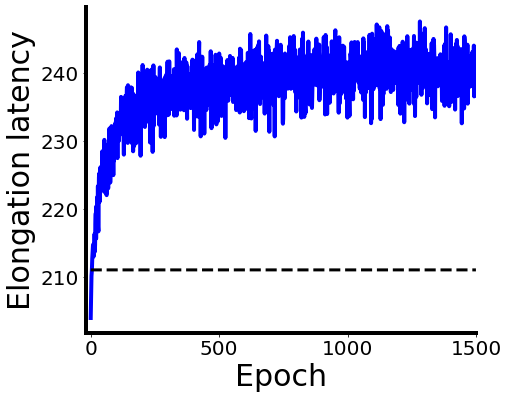

In [14]:
import matplotlib.pyplot as plt
import numpy as np
minelong = np.load('Slower_minelong_arr2-tRNA.npy')

fig,ax = plt.subplots(figsize=(7,6))
ax.plot(np.arange(1500),minelong,linewidth=4,color='blue')
ax.plot(np.arange(1500),[211]*1500,linewidth=3,color='black',linestyle='dashed')
ax.set_xlim(-20,1500)


ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.set_ylabel('Elongation latency',fontsize=30)
ax.set_xlabel('Epoch',fontsize=30)

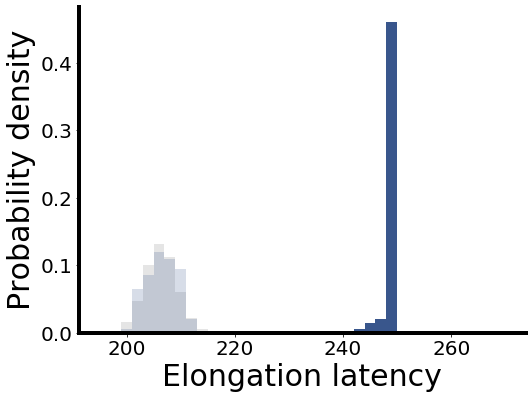

In [21]:
fig,ax = plt.subplots(figsize=(8,6))
#ax.fill_between(np.linspace(160,186.4,2), [0]*2,max(hist[0])*2,alpha=0.1,color='green')


#hist=ax.hist(elong_t_tRNA_list,20,color='grey',density=True)
#ax.plot([186.4]*100,np.linspace(0,max(hist[0]),100),linewidth=3,color='green')
#ax.plot([212]*100,np.linspace(0,max(hist[0]),100),linewidth=3,color='blue')


elong_t_tRNA_list=np.load('Slower_RandomtRNA_FixedCodon_1500sample_elong_t_list2.npy')
hist=ax.hist(elong_t_tRNA_list,15,range=(240,270),color='#39568CFF',density=True)
#ax.plot([186.4]*100,np.linspace(0,max(hist[0]),100),linewidth=3,color='green')
elong_t_tRNA_list=np.load('Slower_RandomtRNA_FixedCodon_1500sample_elong_t_list2_arr-tRNA.npy')[100]
hist=ax.hist(elong_t_tRNA_list,15,range=(240,270),color='#39568CFF',density=True)


p_tRNA_list=np.load('FixedtRNA_RandomCodon_10ksample_p_Codon_tRNA_list.npy')
elong_t_tRNA_list=np.load('FixedtRNA_RandomCodon_10ksample_elong_t_list.npy')
hist=ax.hist(elong_t_tRNA_list,15,range = (195,225),color='grey',density=True,alpha=0.2)
#ax.plot([212]*100,np.linspace(0,max(hist[0]),100),linewidth=3,color='blue')

elong_t_tRNA_list = np.load('FixedtRNA_RandomCodon_100sample_elong_t_list.npy')
hist=ax.hist(elong_t_tRNA_list,15,range = (195,225),color='#39568CFF',density=True,alpha=0.2)
for ax in [ax]:
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', labelsize=20)
    ax.set_ylabel('Probability density',fontsize=30)
    ax.set_xlabel('Elongation latency',fontsize=30)

In [28]:
elong_t_tRNA_list=np.load('Slower_RandomtRNA_FixedCodon_1500sample_elong_t_list2_arr-tRNA.npy')
print(elong_t_tRNA_list[0])


[248.58596672 248.52169167 248.66605751 248.82735443 248.57378476
 248.89808999 248.56035024 248.56206285 248.59690054 248.68718481
 248.54776715 248.61863614 248.21647959 248.61948793 248.79331403
 247.70357122 248.71924511 248.55058156 248.56608159 248.56483934
 248.66010783 248.6618666  248.74260969 245.24304634 248.68792614
 248.56364338 248.76148336 248.73897269 248.84622863 248.63705833
 247.67322657 248.72166701 244.28753362 248.59854605 248.56619763
 249.03385558 248.56930491 248.54323317 248.52688199 248.64607896
 248.6852982  248.74363601 248.61825035 248.66532685 248.75145494
 248.58074459 248.62050478 248.6043633  248.55661021 248.52567544
 248.55055763 248.84727697 248.69819929 248.29624081 248.88214708
 248.90350564 248.5301511  248.7337125  248.74061116 248.74480031
 248.89523525 248.67314154 248.63390777 248.59146398 247.52574139
 248.55052702 248.53946458 248.53605395 248.58945253 248.75884333
 242.7537788  248.54031392 248.65650426 248.70079839 248.64334621
 248.56807

R^2 0.19815760828151796
-0.788795272796071


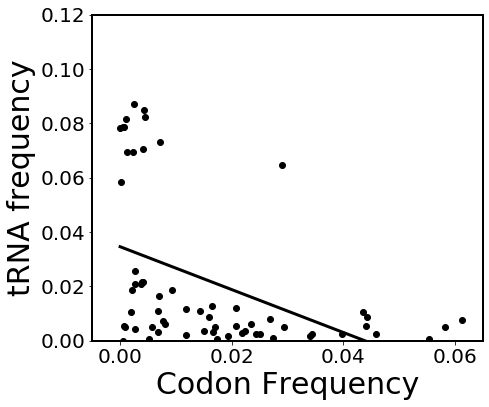

In [20]:
#### trna frequency vs codon frequency, ga slower (tRNA random, codon fixed)
from analysis_utils import *
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
%matplotlib inline
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


gr25_Codon = np.array([2.36, 1.26, 45.55, 34.17, 16.97, 57.86, 19.27, 33.74, 14.98, 22.31, 43.18, 7.67, 24.11, 24.87, 39.49, 11.81, 0.03, 0.63, 2.19, 9.31, 17.22, 55.01, 5.61, 29.21, 21.67, 0.52, 15.79, 43.86, 4.17, 2.61, 20.64, 26.7, 7.03, 0.19, 2.76, 3.81, 6.72, 16.52, 4.27, 2.73, 7.92, 23.25, 2.51, 1.98, 16.33, 11.68, 0.62, 0.67, 43.82, 20.59, 27.28, 7.01, 6.78, 14.21, 60.75, 0.82, 3.86, 4.09, 28.82, 5.18, 4.38, 1.09])
gr25_pCodon = gr25_Codon/np.sum(gr25_Codon)
gr25_ptRNA = [0.0602409638554217, 0.010542168674698798, 0.07379518072289158, 0.00602409638554217, 0.010542168674698798, 0.00602409638554217, 0.021084337349397596, 0.043674698795180725, 0.021084337349397596, 0.01204819277108434, 0.01807228915662651, 0.08433734939759038, 0.03162650602409639, 0.07228915662650603, 0.01204819277108434, 0.07078313253012049, 0.06325301204819278, 0.01656626506024097, 0.009036144578313254, 0.027108433734939763, 0.010542168674698798, 0.03012048192771085, 0.013554216867469882, 0.015060240963855425, 0.0075301204819277125, 0.010542168674698798, 0.0075301204819277125, 0.003012048192771085, 0.021084337349397596, 0.004518072289156627, 0.01656626506024097, 0.01204819277108434, 0.0015060240963855425, 0.009036144578313254, 0.01656626506024097, 0.019578313253012052, 0.015060240963855425, 0.027108434, 0.05873493975903616, 0.019578313]
gr25_ptRNA = gr25_ptRNA/np.sum(gr25_ptRNA)


p_tRNA_list = np.load('Slower_RandomtRNA_FixedCodon_1500sample_p_tRNA_list2.npy')
elong_t_tRNA_list = np.load('Slower_RandomtRNA_FixedCodon_1500sample_elong_t_list2.npy')

ptRNA_dict, pcodon_dict, codon_dict, codon_labels, pCodon = cognateDistrib(p_tRNA_list[np.argmax(elong_t_tRNA_list)],gr25_pCodon,True)

codonp_sorted = sorted(pcodon_dict.items(),key=lambda kv: kv[1])[::-1]
codonp_sorted_codon = [x[0] for x in codonp_sorted]
codonp_sorted_p = [x[1] for x in codonp_sorted]

codon_tRNA_sorted = [codon_dict[codon] for codon in codonp_sorted_codon]

codonp_sorted = sorted(pcodon_dict.items(),key=lambda kv: kv[1])[::-1]
codonp_sorted_codon = [x[0] for x in codonp_sorted]
codonp_sorted_p = [x[1] for x in codonp_sorted]
#print(codonp_sorted)

codon_tRNA_sorted = [codon_dict[codon] for codon in codonp_sorted_codon]
codon_tRNA_sorted_p = [sum(ptRNA_dict[tRNA] for tRNA in codon_dict[codon]) for codon in codonp_sorted_codon]
#ax2 = ax.twinx()
fig,ax = plt.subplots(figsize=(7,6))
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)

ax.scatter(codonp_sorted_p,codon_tRNA_sorted_p,color='black',label = 'Protein-coding codon')
ax.set_xlabel('Codon Frequency',fontsize=30)
ax.set_ylabel('tRNA frequency',fontsize=30)
ax.set_xlim(-0.005,0.065)


def calc_R2(x,y,y_hat):
    SS_err = np.sum((y-y_hat)**2) # Sum of squared errors
    SS_tot = np.sum((y-np.average(y))**2) #Sum of squares total (proportional to variance; n times larger than variance)
    return 1-SS_err/SS_tot

y_model,SS_err,_,_,_ = np.polyfit(codonp_sorted_p,codon_tRNA_sorted_p,1,full=True)
y_hat = np.polyval(y_model,codonp_sorted_p)
x_sweep_i = np.linspace(min(codonp_sorted_p),max(codonp_sorted_p),1000)
y_hat_sweep_i = np.polyval(y_model, x_sweep_i)
ax.plot(x_sweep_i,y_hat_sweep_i,linewidth=3,color='black')
print("R^2",calc_R2(codonp_sorted_p,codon_tRNA_sorted_p,y_hat))

slope, intercept = np.polyfit(codonp_sorted_p,codon_tRNA_sorted_p,1)
print(slope)

ax.set_ylim(0,0.12)


ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

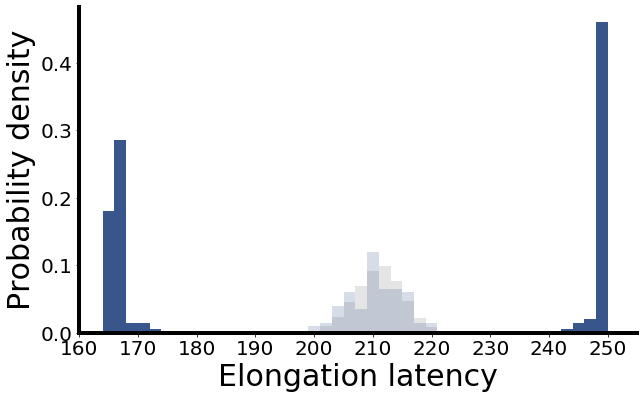

In [44]:
fig,ax = plt.subplots(figsize=(10,6))

p_tRNA_list=np.load('RandomtRNA_FixedCodon_1500sample_p_tRNA_list.npy')
elong_t_tRNA_list=np.load('RandomtRNA_FixedCodon_1500sample_elong_t_list.npy')
hist=ax.hist(elong_t_tRNA_list,15,range=(164,194),color='#39568CFF',density=True)

elong_t_tRNA_list=np.load('Slower_RandomtRNA_FixedCodon_1500sample_elong_t_list2.npy')
hist=ax.hist(elong_t_tRNA_list,15,range=(240,270),color='#39568CFF',density=True)

p_tRNA_list=np.load('RandomtRNA_FixedCodon_10ksample_p_Codon_tRNA_list.npy')
elong_t_tRNA_list=np.load('RandomtRNA_FixedCodon_10ksample_elong_t_list.npy')
hist=ax.hist(elong_t_tRNA_list,15,range = (195,225),color='grey',density=True,alpha=0.2)

elong_t_tRNA_list = np.load('RandomtRNA_FixedCodon_100sample_elong_t_list.npy')
hist=ax.hist(elong_t_tRNA_list,15,range = (195,225),color='#39568CFF',density=True,alpha=0.2)
for ax in [ax]:
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', labelsize=20)
    ax.set_ylabel('Probability density',fontsize=30)
    ax.set_xlabel('Elongation latency',fontsize=30)
    ax.set_xlim(160,255)
    ax.set_xticks(np.arange(160,260,10))

In [21]:
###### Genetic algorithm for just codon shuffling ########

def run_ga_CodonSweep_multithread(tRNA_arr,elong_arr,codon_arr,gr_dict,minRange,maxRange):
    from joblib import Parallel, delayed
    import multiprocessing   
    num_cores = 16

    #### Compute fitness
    fitness = (np.array(elong_arr))/sum((np.array(elong_arr)))

    #### Number of candidates n removing as well as n mating to create n offspring
    n = 10

    #### Identify the least fit candidates from the population
    cull_indices = np.argpartition(fitness, n)[:n]

    #### Choose parents based on weighting fitness
    import random
    #parent_indices = np.array(random.choices(np.arange(len(p_tRNA_list)), fitness, k=10))
    parent_indices = np.argpartition(fitness, n)[-n:]
    codon_arr=np.array(codon_arr)
    parents = codon_arr[parent_indices]

    #### Mate k random pairs of 2 without replacement and renormalize
    k=5
    couples = np.random.choice(np.arange(len(parents)), size = (k,2),replace=False)
    recombination_rate = 0.1
    mutation_rate  = 0.05

    recombined_children = list()
    recombined_children_elongt = list()
    
    syn_codon_list = [[0,1,2,3],[4,5],[6,7],[8,9,10,11],[12,13,14,15],[16,17,46,47,48,49],[18,19,42,43,44,45],
                      [20,21],[22,23],[24],[25,26,27],[28,29,30,31],[32],[33],[34,35],[36,37],[38,39,54,55,56,57],[40,41],
                      [50,51],[52,53],[58,59,60,61]]
    
    for couple_index in couples:
        couple = parents[couple_index]
        recombination_num = int(len(couple[0])*recombination_rate)
        recombination_locs = np.random.choice(len(couple[0]),recombination_num)
        recombination_values_0 = couple[0][recombination_locs] 
        couple[0][recombination_locs] = couple[1][recombination_locs]
        couple[1][recombination_locs] = recombination_values_0
        
        #### Mutate children
        mutation_num = int(len(couple[0])*mutation_rate)
        recombination_locs = np.random.choice(len(couple[0]),mutation_num)
        couple[0][recombination_locs] = np.random.uniform(minRange,maxRange,mutation_num)
        couple[1][recombination_locs] = np.random.uniform(minRange,maxRange,mutation_num)
        
        ### Re-normalize each recombined children
        ##First re-normalize to make sure synonymous codons have, together, the same total frequency (keep the genome the same)
        gr25_Codon = np.array([2.36, 1.26, 45.55, 34.17, 16.97, 57.86, 19.27, 33.74, 14.98, 22.31, 43.18, 7.67, 24.11, 24.87, 39.49, 11.81, 0.03, 0.63, 2.19, 9.31, 17.22, 55.01, 5.61, 29.21, 21.67, 0.52, 15.79, 43.86, 4.17, 2.61, 20.64, 26.7, 7.03, 0.19, 2.76, 3.81, 6.72, 16.52, 4.27, 2.73, 7.92, 23.25, 2.51, 1.98, 16.33, 11.68, 0.62, 0.67, 43.82, 20.59, 27.28, 7.01, 6.78, 14.21, 60.75, 0.82, 3.86, 4.09, 28.82, 5.18, 4.38, 1.09])
        gr25_pCodon = gr25_Codon/np.sum(gr25_Codon)

        syn_codon_list = [[0,1,2,3],[4,5],[6,7],[8,9,10,11],[12,13,14,15],[16,17,46,47,48,49],[18,19,42,43,44,45],
                      [20,21],[22,23],[24],[25,26,27],[28,29,30,31],[32],[33],[34,35],[36,37],[38,39,54,55,56,57],[40,41],
                      [50,51],[52,53],[58,59,60,61]]
        syn_codon_freqs = list()
        for syn_codons in syn_codon_list:
            syn_codon_freqs.append(sum(gr25_pCodon[syn_codons]))
            couple[0][syn_codons] = sum(gr25_pCodon[syn_codons])/sum(couple[0][syn_codons])*couple[0][syn_codons]
            couple[1][syn_codons] = sum(gr25_pCodon[syn_codons])/sum(couple[1][syn_codons])*couple[1][syn_codons]
        child_0 = couple[0]/np.sum(couple[0])
        child_1 = couple[1]/np.sum(couple[1])
        
        ### Add children to list
        recombined_children.append(list(child_0))
        recombined_children.append(list(child_1))
        
    #### Compute elong_t of the recombined children, multithreaded
    inputs=[[tRNA_arr,recombined_children[i],gr_dict] for i in np.arange(len(couples)*2)]
    a = Parallel(n_jobs=num_cores)(delayed(computedElongationLatency_gr3_v2_multithread)(i) for i in inputs)
    for _,items in enumerate(a):
        recombined_children_elongt.append(items[0][0])
    
    #### Have recombined children and their elong_t replaced culled candidates
    codon_arr[cull_indices] = recombined_children
    elong_arr[cull_indices] = recombined_children_elongt
    return fitness, codon_arr, elong_arr

def computedElongationLatency_gr3_v2_multithread(input):
    import numpy as np
    gr25_ptRNA = input[0]
    gr25_pCodon = input[1]
    gr_dict = input[2]
    transportRxnResults = transportRxnCalc(gr_dict,gr25_ptRNA,gr25_pCodon)

    search_list = transportRxnResults[0]
    rxndiff['30'] = transportRxnResults[1:]
    return([rxndiff[d][2][0]+(1000/1475+1000/1529+1000/209+1000/200+1000/32) for d in rxndiff],[rxndiff[d][5][0] for d in rxndiff])

In [22]:
%%time
### tRNA array fixed, codon varying
gr25_Codon = np.array([2.36, 1.26, 45.55, 34.17, 16.97, 57.86, 19.27, 33.74, 14.98, 22.31, 43.18, 7.67, 24.11, 24.87, 39.49, 11.81, 0.03, 0.63, 2.19, 9.31, 17.22, 55.01, 5.61, 29.21, 21.67, 0.52, 15.79, 43.86, 4.17, 2.61, 20.64, 26.7, 7.03, 0.19, 2.76, 3.81, 6.72, 16.52, 4.27, 2.73, 7.92, 23.25, 2.51, 1.98, 16.33, 11.68, 0.62, 0.67, 43.82, 20.59, 27.28, 7.01, 6.78, 14.21, 60.75, 0.82, 3.86, 4.09, 28.82, 5.18, 4.38, 1.09])
gr25_pCodon = gr25_Codon/np.sum(gr25_Codon)
gr25_ptRNA = [0.0602409638554217, 0.010542168674698798, 0.07379518072289158, 0.00602409638554217, 0.010542168674698798, 0.00602409638554217, 0.021084337349397596, 0.043674698795180725, 0.021084337349397596, 0.01204819277108434, 0.01807228915662651, 0.08433734939759038, 0.03162650602409639, 0.07228915662650603, 0.01204819277108434, 0.07078313253012049, 0.06325301204819278, 0.01656626506024097, 0.009036144578313254, 0.027108433734939763, 0.010542168674698798, 0.03012048192771085, 0.013554216867469882, 0.015060240963855425, 0.0075301204819277125, 0.010542168674698798, 0.0075301204819277125, 0.003012048192771085, 0.021084337349397596, 0.004518072289156627, 0.01656626506024097, 0.01204819277108434, 0.0015060240963855425, 0.009036144578313254, 0.01656626506024097, 0.019578313253012052, 0.015060240963855425, 0.027108434, 0.05873493975903616, 0.019578313]
gr25_ptRNA = gr25_ptRNA/np.sum(gr25_ptRNA)
elong_t_codon_list = np.load('FixedtRNA_RandomCodon_100sample_elong_t_list-syn.npy')
p_Codon_list = np.load('FixedtRNA_RandomCodon_100sample_p_Codon_list-syn.npy')


fitness_arr = list()
maxelong_arr = list()
for i in range(1500):
    fitness, p_Codon_list, elong_t_Codon_list = run_ga_CodonSweep_multithread(gr25_ptRNA,elong_t_codon_list,p_Codon_list,gr_dict,min(gr25_pCodon),max(gr25_pCodon))
    print(i)
    print(max(elong_t_Codon_list))
    fitness_arr.append(max(fitness))
    maxelong_arr.append(max(elong_t_Codon_list))
np.save('FixedtRNA_RandomCodon_1500sample_elong_t_list_slow',elong_t_Codon_list)
np.save('FixedtRNA_RandomCodon_1500sample_p_tRNA_list_slow',p_Codon_list)
np.save('maxelong_arr2-RandomCodon_slow',maxelong_arr)


0
205.8761303746694
1
205.8761303746694
2
205.8761303746694
3
205.8761303746694
4
205.8761303746694
5
205.8761303746694
6
205.8761303746694
7
205.8761303746694
8
205.8761303746694
9
205.8761303746694
10
205.8761303746694
11
205.8761303746694
12
205.8761303746694
13
205.8761303746694
14
205.8761303746694
15
205.8761303746694
16
205.8761303746694
17
205.8761303746694
18
205.8761303746694
19
205.8761303746694
20
205.8761303746694
21
205.8761303746694
22
205.8761303746694
23
205.8761303746694
24
205.8761303746694
25
205.8761303746694
26
205.8761303746694
27
205.8761303746694
28
205.8761303746694
29
206.2088205105068
30
206.2088205105068
31
206.2088205105068
32
206.55722320100773
33
207.41657441568518
34
207.41657441568518
35
207.41657441568518
36
207.41657441568518
37
207.41657441568518
38
207.41657441568518
39
207.41657441568518
40
208.44183052591265
41
208.44183052591265
42
208.44183052591265
43
208.44183052591265
44
208.44183052591265
45
208.44183052591265
46
208.44183052591265
47
208.4

366
211.40839896983394
367
211.40839896983394
368
211.40839896983394
369
211.40839896983394
370
211.40839896983394
371
211.40839896983394
372
211.40839896983394
373
211.40839896983394
374
211.40839896983394
375
211.40839896983394
376
211.40839896983394
377
211.40839896983394
378
211.40839896983394
379
211.40839896983394
380
211.40839896983394
381
211.40839896983394
382
211.40839896983394
383
211.40839896983394
384
211.40839896983394
385
211.40839896983394
386
211.40839896983394
387
211.40839896983394
388
211.40839896983394
389
211.40839896983394
390
211.40839896983394
391
211.40839896983394
392
211.40839896983394
393
211.40839896983394
394
211.40839896983394
395
211.40839896983394
396
211.40839896983394
397
211.40839896983394
398
211.40839896983394
399
211.40839896983394
400
211.40839896983394
401
211.40839896983394
402
211.40839896983394
403
211.40839896983394
404
211.40839896983394
405
211.40839896983394
406
211.40839896983394
407
211.40839896983394
408
211.40839896983394
409
211.408

728
212.679098823438
729
212.679098823438
730
212.679098823438
731
212.679098823438
732
212.679098823438
733
212.679098823438
734
212.679098823438
735
212.679098823438
736
212.679098823438
737
212.679098823438
738
212.679098823438
739
212.679098823438
740
212.679098823438
741
212.679098823438
742
212.679098823438
743
212.679098823438
744
212.679098823438
745
212.679098823438
746
212.679098823438
747
212.679098823438
748
212.679098823438
749
212.679098823438
750
212.679098823438
751
212.679098823438
752
212.679098823438
753
212.679098823438
754
212.679098823438
755
212.679098823438
756
212.679098823438
757
212.679098823438
758
212.679098823438
759
212.679098823438
760
212.679098823438
761
212.679098823438
762
212.679098823438
763
212.679098823438
764
212.679098823438
765
212.679098823438
766
212.679098823438
767
212.679098823438
768
212.679098823438
769
212.679098823438
770
212.679098823438
771
212.679098823438
772
212.679098823438
773
212.679098823438
774
212.679098823438
775
212.67909

1113
212.679098823438
1114
212.679098823438
1115
212.679098823438
1116
212.679098823438
1117
212.679098823438
1118
212.679098823438
1119
212.679098823438
1120
212.679098823438
1121
212.679098823438
1122
212.679098823438
1123
212.679098823438
1124
212.679098823438
1125
212.679098823438
1126
212.679098823438
1127
212.679098823438
1128
212.679098823438
1129
212.679098823438
1130
212.679098823438
1131
212.679098823438
1132
212.679098823438
1133
212.679098823438
1134
212.679098823438
1135
212.679098823438
1136
212.679098823438
1137
212.679098823438
1138
212.679098823438
1139
212.679098823438
1140
212.679098823438
1141
212.679098823438
1142
212.679098823438
1143
212.679098823438
1144
212.679098823438
1145
212.679098823438
1146
212.679098823438
1147
212.679098823438
1148
212.679098823438
1149
212.679098823438
1150
212.679098823438
1151
212.679098823438
1152
212.679098823438
1153
212.679098823438
1154
212.679098823438
1155
212.679098823438
1156
212.679098823438
1157
212.679098823438
1158
212.6

1470
212.84177044371833
1471
212.84177044371833
1472
212.84177044371833
1473
212.84177044371833
1474
212.84177044371833
1475
212.84177044371833
1476
212.84177044371833
1477
212.84177044371833
1478
212.84177044371833
1479
212.84177044371833
1480
212.84177044371833
1481
212.84177044371833
1482
212.84177044371833
1483
212.84177044371833
1484
212.84177044371833
1485
212.84177044371833
1486
212.84177044371833
1487
212.84177044371833
1488
212.84177044371833
1489
212.84177044371833
1490
212.84177044371833
1491
212.84177044371833
1492
212.84177044371833
1493
212.84177044371833
1494
212.84177044371833
1495
212.84177044371833
1496
212.8454431580266
1497
212.8454431580266
1498
212.8454431580266
1499
212.8454431580266
CPU times: user 20min 3s, sys: 6.66 s, total: 20min 10s
Wall time: 1h 6min 47s


In [17]:
RED20_pCodon = pd.read_excel('codonValues_RED20.xlsx',header=None)
RED20_pCodon = RED20_pCodon[6]/sum(RED20_pCodon[6])

computedElongationLatency_gr3_v2_multithread([gr25_ptRNA,RED20_pCodon,gr_dict])

([199.16264738530575], [13.123494413537825])